In [1]:
#import packages
import gym
import numpy as np
import matplotlib.pylab as plt
import random as r
import math as m

In [2]:
# import neural network characteristics from keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


Using TensorFlow backend.


In [3]:
#initialize memory class
class MemoryRL:
    # initialization function
    def __init__(self, mem_max):
        self.mem_max = mem_max
        self.samps = []

    # appending function
    def append_sample(self, sample):
        self.samps.append(sample)
        if len(self.samps) > self.mem_max:
            self.samps.pop(0)

    # sample generation function
    def generate(self, samp_nos):
        if samp_nos > len(self.samps):
            return r.sample(self.samps, len(self.samps))
        else:
            return r.sample(self.samps, samp_nos)

In [4]:
class AgentRL:
    # agent parameters initialization
    def __init__(self, env):
        self.env = env
        self.memory = MemoryRL(5000)
        self.model = self.create_model()
        self.target = self.create_model()

        # initialize parameters
        self.epsilon_max = 1
        self.epsilon_min = 0.01
        self.gamma_p = 0.99
        self.batch_size = 50
        self.lamda = 0.0001
        self.tau = 0.099
        
    #define deep neural network model
    def create_model(self):
        agent = Sequential()
        s_shape = self.env.observation_space.shape
        agent.add(Dense(50, input_dim=s_shape[0], activation="relu"))
        agent.add(Dense(50, activation="relu"))
        agent.add(Dense(self.env.action_space.n))
        agent.compile(loss="mean_squared_error", optimizer=Adam(lr=0.02))
        return agent
    
    #create function for action selection
    def select_action(self, state, step):
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min)* m.exp(-self.lamda *step)
        if np.random.random() < epsilon:
            return r.randint(0, self.env.action_space.n - 1)
        else:
            return np.argmax(self.model.predict(state)[0])
    
    #create function for updating the agent information
    def capture_memory(self, state, action, reward, new_state, done):
        self.memory.append_sample((state, action, reward, new_state, done))
        
    #create function for q-updates
    def replay(self):
        batch_size = self.batch_size
        samples = self.memory.generate(batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            Q_val = self.target.predict(state)
            next_Q = self.target.predict(new_state)
            if done:
                Q_val[0][action] = reward
            else:
                next_Q = np.amax(next_Q)
                Q_val[0][action] = reward + next_Q * self.gamma_p
            self.model.fit(state, Q_val, epochs=1, verbose=0)
    
    #create function for updating the weights of the network
    def train(self):
        weights = self.model.get_weights()
        target_weights = self.target.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target.set_weights(target_weights)
    
        

Episode 1 of 10
Steps 200, total reward -115.0
Episode 2 of 10
Steps 200, total reward -119.0
Episode 3 of 10
Steps 200, total reward -131.0
Episode 4 of 10
Steps 200, total reward -122.0
Episode 5 of 10
Steps 200, total reward -136.0
Episode 6 of 10
Steps 200, total reward -126.0
Episode 7 of 10
Steps 200, total reward -124.0
Episode 8 of 10
Steps 200, total reward -117.0
Episode 9 of 10
Steps 200, total reward -119.0
Episode 10 of 10
Steps 200, total reward -119.0


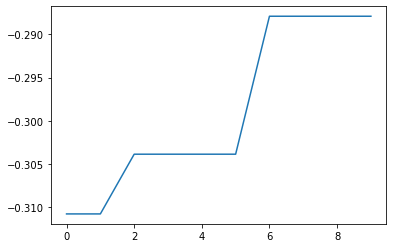

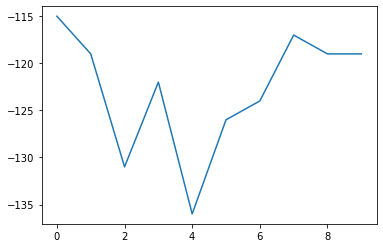

In [5]:
#main function
if __name__ == "__main__":
    #generate the mountain car model
    env = gym.make("MountainCar-v0")
    trials = 10
    trial_len = 200
    dqn_agent = AgentRL(env=env)
    count_trials = 0
    stored_reward = []
    max_state = -100
    stored_f_state = []
    
    #for loop for episodes initialize state and reward
    for trial in range(trials):
        if trials % 10 == 0:
            print("Episode {} of {}".format(trial+1, trials))
        current_state = env.reset()
        current_state= np.reshape(current_state,[1, 2])
        total_reward = 0
        step_count = 0
        # for loop for steps, update action and pass unformation to env. 
        for step in range(trial_len):
            env.render()
            action = dqn_agent.select_action(current_state, step + 1)
            new_state, reward, done, info = env.step(action)
            
            #reset reward values as positive rewards for states closer to the optimum
            if new_state[0] >= -0.5:
                reward += 1
            elif new_state[0] >= -0.1:
                reward += 5
            elif new_state[0] >= 0.1:
                reward += 10
            elif new_state[0] >= 0.25:
                reward += 20
            elif new_state[0] >= 0.5:
                reward += 100

            if new_state[0] > max_state:
                max_state = new_state[0]
            new_state = np.reshape(new_state,[1, 2])

            #update memory with newly generated values, replay and train
            dqn_agent.capture_memory(current_state, action, reward, new_state, done)
            dqn_agent.replay()
            dqn_agent.train()
            
            #update move to the new state unless the end of the episode
            current_state = new_state
            total_reward += reward
            step_count += 1
            if done:
                break
        #update total reward and final state printout steps and reward    
        stored_reward.append(total_reward)
        stored_f_state.append(max_state)
        print("Steps {}, total reward {}".format(step_count, total_reward))
    #plot the final states achieved and rewards for the episodes
    plt.plot(stored_f_state)
    plt.show()
    plt.close("all")
    plt.plot(stored_reward)
    plt.show()
        
    